In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset

In [34]:
# 加载数据集
ds = load_dataset("ethz/food101")

In [35]:
# 获取训练集和测试集
train_ds = ds["train"]
test_ds = ds["validation"]

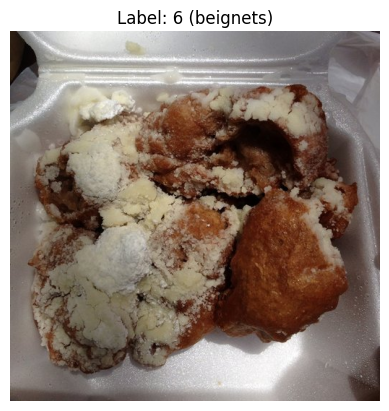

In [36]:
def show_sample(dataset, idx):
    # 获取类别名称列表
    class_names = dataset.features['label'].names
    
    sample = dataset[idx]
    img = sample['image']
    label_idx = sample['label']
    label_name = class_names[label_idx]  # 将数字标签转换为名称
    
    plt.imshow(img)
    plt.title(f"Label: {label_idx} ({label_name})")  # 同时显示数字和名称
    plt.axis('off')
    plt.show()

show_sample(train_ds, 150)  # 查看第10个样本

### ResNet50

In [37]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [38]:
# 定义数据增强和预处理
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [39]:
# 自定义 Dataset 类
class FoodDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.class_names = dataset.features["label"].names

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label = item["label"]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 创建 Dataset 和 DataLoader
train_dataset = FoodDataset(train_ds, transform=train_transform)
test_dataset = FoodDataset(test_ds, transform=val_transform)



In [40]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 加载预训练 ResNet50 并修改分类头
model = models.resnet50(pretrained=True)

# 冻结所有卷积层（可选）
for param in model.parameters():
    param.requires_grad = False

# 替换最后的全连接层
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 101)  # Food-101 有 101 类
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [45]:
from tqdm.auto import tqdm  # 导入tqdm

def train(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 训练阶段（添加进度条）
        train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 实时更新进度条显示
            train_loop.set_postfix({
                'Loss': f"{running_loss/(total/len(train_loader.dataset)):.4f}",
                'Acc': f"{100 * correct / total:.2f}%"
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # 验证阶段（添加进度条）
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        test_loop = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]', leave=False)
        with torch.no_grad():
            for images, labels in test_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                test_loop.set_postfix({
                    'Loss': f"{test_loss/(total/len(test_loader.dataset)):.4f}",
                    'Acc': f"{100 * correct / total:.2f}%"
                })
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        359620

        # 打印每个epoch的最终结果
        print(f"\nEpoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# 开始训练（现在会显示进度条！）
train(model, train_loader, test_loader, criterion, optimizer, epochs=1)

In [ ]:
# 保存模型
torch.save(model.state_dict(), "food101_resnet50.pth")

# 预测示例
def predict(image_path, model, class_names, transform):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
    
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {class_names[predicted.item()]}")
    plt.axis("off")
    plt.show()

# 测试预测
class_names = train_dataset.class_names
predict("your_image.jpg", model, class_names, val_transform)

In [46]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("nateraw/food")
model = AutoModelForImageClassification.from_pretrained("nateraw/food")

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/344M [00:00<?, ?B/s]

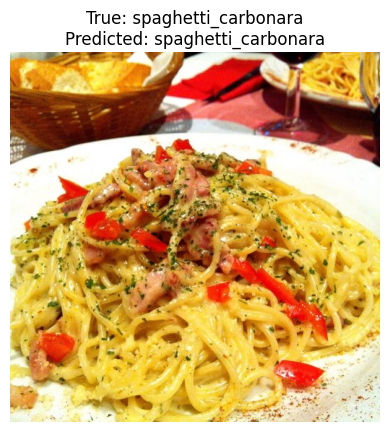

In [60]:
import random

def predict_single_sample(idx):
    # 获取样本
    sample = test_ds[idx]
    image = sample["image"]
    true_label = test_ds.features["label"].names[sample["label"]]
    
    # 预处理和预测
    inputs = processor(image, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 获取预测结果
    predicted_label = model.config.id2label[torch.argmax(outputs.logits).item()]
    
    # 可视化
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# 测试第10个样本
predict_single_sample(random.randint(0, len(test_ds)))

In [48]:
from tqdm.auto import tqdm

def evaluate_model(test_dataset, num_samples=1000):
    correct = 0
    total = min(num_samples, len(test_dataset))
    
    for idx in tqdm(range(total), desc="Evaluating"):
        sample = test_dataset[idx]
        image = sample["image"]
        true_label = sample["label"]
        
        # 预处理和预测
        inputs = processor(image, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 检查预测是否正确
        predicted_label = torch.argmax(outputs.logits).item()
        if predicted_label == true_label:
            correct += 1
    
    accuracy = 100 * correct / total
    print(f"Accuracy on {total} samples: {accuracy:.2f}%")

# 评估前1000个测试样本
evaluate_model(test_ds, num_samples=1000)

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on 1000 samples: 91.00%
